In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 8.7MB/s 
     |████████████████████████████████| 1.0MB 56.0MB/s 
     |████████████████████████████████| 3.7MB 29kB/s 
     |████████████████████████████████| 890kB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=93bceb0477d4c33bb74758b1275cf49ef336b75b0b318f8aa5ffe586fda157b0
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import os
import sys
import torch
import csv
import numpy as np
import random
import time
import datetime
import pprint


In [0]:
home_dir = "gdrive/My Drive/propaganda_detection"
data_dir = os.path.join(home_dir, "datasets")
model_dir = os.path.join(home_dir, "model_dir")
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [0]:
# Read training articles
def read_articles(dir_name):
  articles = []
  train_dir = os.path.join(data_dir, dir_name)
  for filename in sorted(os.listdir(train_dir)):
    myfile = open(os.path.join(train_dir, filename))
    article = myfile.read()
    articles.append(article)
    myfile.close()
  article_ids = []
  for filename in sorted(os.listdir(train_dir)):
    article_ids.append(filename[7:-4])
  
  return articles, article_ids

In [0]:
# Read training span labels 
def read_spans(mode=None):
  spans = []
  techniques = []
  if mode == "test":
    label_dir = os.path.join(data_dir, "dev-task-TC-template.out")
  else:
    label_dir = os.path.join(data_dir, "train-labels-task2-technique-classification")
  for filename in sorted(os.listdir(label_dir)):
    myfile = open(os.path.join(label_dir, filename))
    tsvreader = csv.reader(myfile, delimiter="\t")
    span = []
    technique = []
    for row in tsvreader:
      span.append((int(row[2]), int(row[3])))
      if mode == "test":
        technique.append("Slogans") # DUMMY
      else:
        technique.append(row[1])
    myfile.close()
    spans.append(span)
    techniques.append(technique)
  return spans, techniques

In [0]:
# Read training span labels 
def read_test_spans():
  spans = []
  techniques = []
  label_file = os.path.join(data_dir, "dev-task-TC-template.out")
  myfile = open(label_file)
  prev_index = -1
  tsvreader = csv.reader(myfile, delimiter="\t")

  span = []
  technique = []
  for row in tsvreader:
    article_index = int(row[0])
    if article_index != prev_index:
      if prev_index != -1:
        spans.append(span)
        techniques.append(technique)
      span = []
      technique = []
      span.append((int(row[2]), int(row[3])))
      technique.append("Slogans")
      prev_index = article_index
    else:
      span.append((int(row[2]), int(row[3])))
      technique.append("Slogans")
  spans.append(span)
  techniques.append(technique)
  return spans, techniques, 

In [0]:
def print_spans(article, span, technique):
  for index, sp in enumerate(span):
    print(technique[index], tag2idx[technique[index]], end=' - ')
    print (article[sp[0]: sp[1]])
  print()

In [0]:
def get_context(article, span, mode=None):
  def get_num_words(sentence):
    return len(sentence.split(' '))
  if mode == "title":
    return article.split('\n')[0]
  if mode == "sentence":
    WORD_LEN_LIMIT = 120
    li = span[0]
    ri = span[1]
    span_text = article[li: ri]
    num_words = get_num_words(span_text)
    if num_words >= WORD_LEN_LIMIT:
      return span_text
    remaining_len = WORD_LEN_LIMIT - num_words
    lhs_words = remaining_len // 2
    rhs_words = remaining_len - lhs_words
    li -= 1
    lcount = 0
    while li >= 0 and article[li] != '\n' and lcount < lhs_words:
      if article[li] == ' ':
        lcount += 1
      li -= 1
    ri += 1
    rcount = 0
    while ri < len(article) and article[ri] != '\n' and rcount < rhs_words:
      if article[ri] == ' ':
        rcount += 1
      ri += 1
    return article[li+1: ri - 1] 

  return ""

In [0]:
def get_examples(articles, spans, techniques, context_mode=None):
  assert len(articles) == len(spans) and len(spans) == len(techniques)
  sentences = []
  labels = []
  sent_contexts = []
  for index, article in enumerate(articles):
    span = spans[index]
    technique = techniques[index]
    assert len(technique) == len(span)
    for i, sp in enumerate(span):
      pt = tag2idx[technique[i]]
      sentence = article[sp[0]: sp[1]]
      sentences.append(sentence)
      labels.append(pt)
      context = get_context(article, sp, context_mode)
      sent_contexts.append(context)
  return sentences, labels, sent_contexts

In [0]:
from transformers import BertForTokenClassification
from keras.preprocessing.sequence import pad_sequences
def convert_sentence_to_input_feature(sentence, tokenizer, add_cls_sep=True, max_seq_len=150, context=None):
  tokenized_sentence = tokenizer.encode_plus(sentence,
                                             add_special_tokens=add_cls_sep,
                                             max_length=max_seq_len,
                                             pad_to_max_length=True,
                                             return_attention_mask=True)
  tokenized_context = tokenizer.encode_plus(context,
                                            add_special_tokens=add_cls_sep,
                                            max_length=max_seq_len,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)
  return tokenized_sentence['input_ids'], tokenized_sentence['attention_mask'], tokenized_context['input_ids'], tokenized_context['attention_mask']

Using TensorFlow backend.


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def get_data(articles, spans, techniques, context_mode=None):
  if context_mode is None:
    context_mode = CONTEXT_MODE
  sentences, labels, contexts = get_examples(articles, spans, techniques, context_mode=context_mode)
  s_attention_masks = []
  s_inputs = []
  c_attention_masks = []
  c_inputs = []
  for i, sentence in enumerate(sentences):
    s_input_ids, s_mask, c_input_ids, c_mask = convert_sentence_to_input_feature(sentence, tokenizer, context=contexts[i])
    s_inputs.append(s_input_ids)
    s_attention_masks.append(s_mask)
    c_inputs.append(c_input_ids)
    c_attention_masks.append(c_mask)

  max_sent_len = 0
  for sent in sentences:
    sent_len = len(sent.split(' '))
    max_sent_len = max(max_sent_len, sent_len)
  max_context_len = 0
  for sent in contexts:
    sent_len = len(sent.split(' '))
    max_context_len = max(max_context_len, sent_len)
  print(max_sent_len, max_context_len)

  s_inputs = torch.tensor(s_inputs)
  c_inputs = torch.tensor(c_inputs)
  labels = torch.tensor(labels)
  s_masks = torch.tensor(s_attention_masks)
  c_masks = torch.tensor(c_attention_masks)
  tensor_data = TensorDataset(s_inputs, labels, s_masks, c_inputs, c_masks)
  dataloader = DataLoader(tensor_data, batch_size=BATCH_SIZE)
  return dataloader

In [0]:
from sklearn import metrics

def compute_metrics(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  print(metrics.confusion_matrix(labels_flat, pred_flat))
  print(metrics.classification_report(labels_flat, pred_flat))

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
from torch.nn import CrossEntropyLoss, MSELoss

class ContextualBertForSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels, ContextModel, SpanModel):
    super(ContextualBertForSequenceClassification, self).__init__()
    self.ContextModel = ContextModel
    self.SpanModel = SpanModel
    self.num_labels = num_labels

    # self.classifier = torch.nn.Linear(768*2, num_labels)
    # self.classifier1 = torch.nn.Linear(768, num_labels)
    self.classifier2 = torch.nn.Linear(768+128, num_labels)
    self.reduce_classifier = torch.nn.Linear(768, 128)
    self.dropout = torch.nn.Dropout(0.1)

  def forward(
      self,
      span_input_ids,
      span_attention_mask,
      context_input_ids,
      context_attention_mask,
      labels=None
  ):
    context_outputs = self.ContextModel(
        input_ids=context_input_ids,
        attention_mask=context_attention_mask
    )
    context_outputs = context_outputs[1] # pooler output
    span_outputs = self.SpanModel(
        input_ids=span_input_ids,
        attention_mask=span_attention_mask
    )
    span_outputs = span_outputs[1]

    context_outputs = self.reduce_classifier(context_outputs)
    pooled_output = torch.cat((span_outputs, context_outputs), axis=1)

    pooled_output = self.dropout(pooled_output)

    logits = self.classifier2(pooled_output)
    outputs = (logits,)
    if labels is not None:
      if self.num_labels == 1:
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs

In [0]:
def train(model, epochs=5):
  loss_values = []
  for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
      if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      b_input_mask = batch[2].to(device)
      b_c_input_ids = batch[3].to(device)
      b_c_input_mask = batch[4].to(device)
      model.zero_grad()        
      outputs = model(b_input_ids, 
                      b_input_mask,
                      b_c_input_ids, 
                      b_c_input_mask, 
                      labels=b_labels)
      loss = outputs[0]
      total_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step() # TODO
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in eval_dataloader:
      # batch = tuple(t.to(device) for t in batch)
      b_input_ids = batch[0].to(device)
      b_labels = batch[1].to(device)
      b_input_mask = batch[2].to(device)
      b_c_input_ids = batch[3].to(device)
      b_c_input_mask = batch[4].to(device)
      with torch.no_grad():        
        outputs = model(b_input_ids, 
                        b_input_mask,
                        b_c_input_ids, 
                        b_c_input_mask)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = flat_accuracy(logits, label_ids)
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
  print("")
  print("Training complete!")

In [0]:
def get_model_predictions(model, dataloader):
  model.eval()
  predictions , true_labels = [], []
  nb_eval_steps = 0
  for batch in dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_input_mask = batch[2].to(device)
    b_c_input_ids = batch[3].to(device)
    b_c_input_mask = batch[4].to(device)
    with torch.no_grad():        
      logits = model(b_input_ids, 
                     b_input_mask,
                     b_c_input_ids, 
                     b_c_input_mask)
    logits = logits[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred_label = np.argmax(logits, axis=1)
    predictions.extend(pred_label)
    true_labels.extend(label_ids)
  return predictions, true_labels

In [0]:
from google.colab import files

def get_dev_predictions(model):
  test_articles, _ = read_articles("dev-articles")
  test_spans, test_techniques = read_test_spans()

  test_articles = test_articles[1:]
  test_dataloader = get_data(test_articles, test_spans, test_techniques)
  pred, _ = get_model_predictions(model, test_dataloader)

  with open('predictions.txt', 'w') as fp:
    label_file = os.path.join(data_dir, "dev-task-TC-template.out")
    myfile = open(label_file)
    prev_index = -1
    tsvreader = csv.reader(myfile, delimiter="\t")
    for i, row in enumerate(tsvreader):
      fp.write(row[0] + '\t' + distinct_techniques[pred[i]] + '\t' + row[2] + '\t' + row[3] + '\n')

In [0]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import RobertaTokenizer

articles, article_ids = read_articles("train-articles")
spans, techniques = read_spans()
distinct_techniques = list(set([y for x in techniques for y in x])) # idx to tag
tag2idx = {t: i for i, t in enumerate(distinct_techniques)}
pprint.pprint(tag2idx)

NUM_ARTICLES = len(articles)

articles = articles[0:NUM_ARTICLES]
spans = spans[0:NUM_ARTICLES]
techniques = techniques[0:NUM_ARTICLES]
BATCH_SIZE=8

seed_val = 1328
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

indices = np.arange(NUM_ARTICLES)
test_size = 0.1
train_articles, eval_articles, train_spans, eval_spans, train_techniques, eval_techniques, train_indices, eval_indices = train_test_split(articles, spans, techniques, indices, test_size=test_size)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', lower_case=True)

CONTEXT_MODE = "sentence" # sentence or title

train_dataloader = get_data(train_articles, train_spans, train_techniques)
eval_dataloader = get_data(eval_articles, eval_spans, eval_techniques)

{'Appeal_to_Authority': 1,
 'Appeal_to_fear-prejudice': 13,
 'Bandwagon,Reductio_ad_hitlerum': 4,
 'Black-and-White_Fallacy': 5,
 'Causal_Oversimplification': 7,
 'Doubt': 2,
 'Exaggeration,Minimisation': 11,
 'Flag-Waving': 9,
 'Loaded_Language': 6,
 'Name_Calling,Labeling': 10,
 'Repetition': 12,
 'Slogans': 0,
 'Thought-terminating_Cliches': 8,
 'Whataboutism,Straw_Men,Red_Herring': 3}
133 133
93 93


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaModel
from transformers import BertModel
from transformers import RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(distinct_techniques)

context_model = RobertaModel.from_pretrained("roberta-base")
span_model = RobertaModel.from_pretrained("roberta-base")
model = ContextualBertForSequenceClassification(num_labels, context_model, span_model)
model.cuda()

optimizer = AdamW(model.parameters(),lr = 3e-5,eps = 1e-8) # ler = 5e-5
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
train(model, epochs=epochs)



======== Epoch 1 / 3 ========
Training...
  Batch   100  of    691.    Elapsed: 0:00:32.
  Batch   200  of    691.    Elapsed: 0:01:04.
  Batch   300  of    691.    Elapsed: 0:01:36.
  Batch   400  of    691.    Elapsed: 0:02:08.
  Batch   500  of    691.    Elapsed: 0:02:39.
  Batch   600  of    691.    Elapsed: 0:03:11.

  Average training loss: 1.70
  Training epcoh took: 0:03:40

Running Validation...
  Accuracy: 0.66
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch   100  of    691.    Elapsed: 0:00:32.
  Batch   200  of    691.    Elapsed: 0:01:04.
  Batch   300  of    691.    Elapsed: 0:01:35.
  Batch   400  of    691.    Elapsed: 0:02:07.
  Batch   500  of    691.    Elapsed: 0:02:39.
  Batch   600  of    691.    Elapsed: 0:03:11.

  Average training loss: 1.18
  Training epcoh took: 0:03:40

Running Validation...
  Accuracy: 0.71
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...
  Batch   100  of    691.    Elapsed: 0:00:32.
 

In [0]:
get_dev_predictions(model)

In [0]:
files.download('predictions.txt')

In [0]:
s, t = get_model_predictions(model, train_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

s, t = get_model_predictions(model, eval_dataloader)
print (len(s), len(t))
print(metrics.confusion_matrix(t, s))
print(metrics.classification_report(t, s))

5679 5679
[[ 383    0    1    1    5   22    1    1    3    5    0    2    1    1]
 [   1  104    0    1   14    1    1    2    7    1    1    1    0    0]
 [   1    0  110    0    0    1    0    0    5    0    0    2    0    0]
 [   0    2    0  183    3    1    3    0    0    0    3    1    1    1]
 [   3    2    3    3  226   11    0    2    6    1    2    2    1    0]
 [  38    0    4    2    7 1852    2    0   13   18    0    4    0    0]
 [   4    1    0    9    1    2  423    0    2    2    0    3    0    2]
 [   2    0    2    3    0    6    0   54    0    0    2    0    0    0]
 [   5    4   11    0    3   52    4    3  466   31    2   16    0    0]
 [   3    0    0    0    0   30    1    0   12  959    0    0    2    0]
 [   1    0    0    5    8    0    1    4    0    0   78    2    1    0]
 [   0    1    4    2    2    0    2    0    0    1    1  204    0    0]
 [   2    8    0    8    1    0    1    0    0    1    7    1   36    1]
 [   0    7    0    7    3    0   18    0

### Span Length Distribution

In [0]:
counts = {}
max_diff = 50000
sls = []
sls2 = []
lengths = {}
for index, tech in enumerate(techniques):
  sp = spans[index]
  for i, t in enumerate(tech):
    s = sp[i]
    sls2.append(s[1] - s[0])
    if t in lengths:
      lengths[t].append(s[1] - s[0])
    else:
      lengths[t] = [s[1] - s[0]]
    if t in counts:
      if s[1] - s[0] < max_diff:
        counts[t] += 1
        sls.append(s[1] - s[0])
    else:
      if s[1] - s[0] < max_diff:
        counts[t] = 1
        sls.append(s[1] - s[0])
pprint.pprint(counts)
print(np.mean(sls))
print(np.mean(sls2))
for t in lengths:
  print(t, np.mean(lengths[t]))
  print(t, np.median(lengths[t]))

category1 = {'Loaded_Language': 1947,
 'Name_Calling,Labeling': 960,
 'Repetition': 587,
 'Slogans': 121,
 'Thought-terminating_Cliches': 64,
 'Exaggeration,Minimisation': 0,
 'Flag-Waving':0}
lengths1 = []
lengths2 = []

for t in lengths:
  if t in category1:
    lengths1 += lengths[t]
  else:
    lengths2 += lengths[t]

{'Appeal_to_Authority': 144,
 'Appeal_to_fear-prejudice': 294,
 'Bandwagon,Reductio_ad_hitlerum': 72,
 'Black-and-White_Fallacy': 107,
 'Causal_Oversimplification': 209,
 'Doubt': 493,
 'Exaggeration,Minimisation': 466,
 'Flag-Waving': 229,
 'Loaded_Language': 2123,
 'Name_Calling,Labeling': 1058,
 'Repetition': 621,
 'Slogans': 129,
 'Thought-terminating_Cliches': 76,
 'Whataboutism,Straw_Men,Red_Herring': 108}
48.34377549355523
48.34377549355523
Appeal_to_Authority 138.95833333333334
Appeal_to_Authority 94.5
Doubt 124.7971602434077
Doubt 97.0
Repetition 17.784219001610307
Repetition 13.0
Appeal_to_fear-prejudice 98.58503401360544
Appeal_to_fear-prejudice 79.0
Slogans 25.093023255813954
Slogans 22.0
Black-and-White_Fallacy 105.29906542056075
Black-and-White_Fallacy 90.0
Loaded_Language 24.48657560056524
Loaded_Language 18.0
Flag-Waving 61.88209606986899
Flag-Waving 39.0
Name_Calling,Labeling 26.32703213610586
Name_Calling,Labeling 21.0
Whataboutism,Straw_Men,Red_Herring 97.14814814814

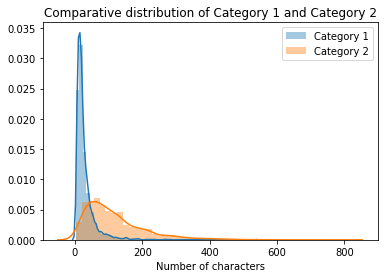

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(lengths1, label='Category 1')
sns.distplot(lengths2, label='Category 2')
# sns.distplot(lengths['Slogans'])
# sns.distplot(lengths['Causal_Oversimplification'])
# sns.distplot(lengths['Slogans'], kde=False)
# sns.distplot(lengths['Causal_Oversimplification'], kde=False)
# for s in category1:
#   sns.distplot(lengths[s])
plt.legend()
plt.xlabel('Number of characters')
plt.title('Comparative distribution of Category 1 and Category 2')
plt.savefig('comparative.png')

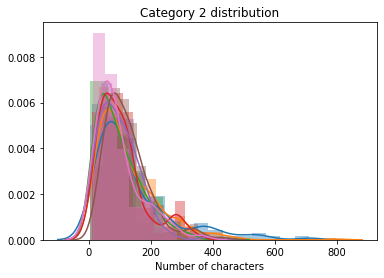

In [0]:
for s in lengths:
  if s not in category1:
    sns.distplot(lengths[s])
plt.xlabel('Number of characters')
plt.title('Category 2 distribution')
plt.savefig('Category2.png')

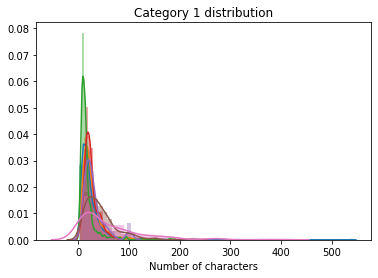

In [0]:

for s in category1:
  sns.distplot(lengths[s])
plt.xlabel('Number of characters')
plt.title('Category 1 distribution')
plt.savefig('Category1.png')

In [0]:
for s in category1:
  print(s, end=', ')

Loaded_Language, Name_Calling,Labeling, Repetition, Slogans, Thought-terminating_Cliches, Exaggeration,Minimisation, Flag-Waving, 